In [1]:
import casadi as ca
import numpy as np
import sympy as sy

## OCP Solver

Reference:
1. [casadi multiple shooting](https://github.com/casadi/casadi/blob/master/docs/examples/python/direct_multiple_shooting.py)
2. Moritz Diehl et al., 2009. Fast Direct Multiple Shooting Algorithms for Optimal Robot Control.
3. ‪Lorenz T. Biegler‬. Nonlinear Programming: Concepts, Algorithms, and Applications to Chemical Processes Lorenz Theodor Biegler

The purpose of this program is to demonstrate how to solve a DAE-constrianed optimization problem. All the solving methods can be divided into two directions: indirect method and direct method. The indirect method solves a boundary value problem in ODE. This method is usually called *first optimize, then discretize*, since the conditions of optimality are at first written in a continuous-time formulation, and then discretized for a numerical solution.

The direct method - an more general and computationally efficient method - transform the DAE-constrianed optimization problem into nonlinear program (NLP). This approach is also well known as *first discretize then optimize* strategy. The direct method can be further classified as single shooting, multiple shooting and collocation method, based on their way to handle the continuous-time DAE. In the following, only direct method will be considered.

A standard dynamic optimzation strategy therefore incorporates three parts: DAE solver, Sensitivity Calculations and NLP Solver.

DAE Solver：DAE solver applies numerical methods to find the solution of initial value problems. Single shooting method only discretizes the control variables, and DAE model is integrated w.r.t. the given control varibles and the initial condition. The multiple shooting method discretizes the control varible and states simultaneously, and the DAE is integrated in small elements (within each discretization interval). Extra equality constraints following the continuity condition across boundary of the intervals should be included. The collocation simultaneously discretizes the state and control profiles as well. It approximates each state profile in the elements with a polynomial. Extra equality constraints following the continuity condition will be needed.

Sensitivity Calculation: Deals with efficient and accurate gradient calculations
for the NLP solver.


NLP solver:
Two NLP solver are widely applied: 1. Interior point method 2. SQP.
We use the ipopt plugin in the Casadi NLP solver to find the numerical solution.





In [32]:
def ode_ca(t, x, u):
    '''
    Example system
    
    Args:
        t: Current time.
        x: Current value (list or numpy array). 
        u. Current input (list or numpy array)
        
    Returns: First order ODE in casadi SX col vector .
    '''
    # Parameter konfiguration
    rhs = [(1-x[1]**2)*x[0] - x[1] + u[0],
           x[0]
          ]
    return ca.vertcat(*rhs)

In [42]:
def multiple_shooting(fn, l, t_var, x_var, u_var, N, h, lt=None, solver_opt=None, g_model = None):
    '''
    Solve the ODE for the NLP solver with multiple shooting optimization formulation.

    Args:
        fn: Discretized ODE function in casadi function (Nt x Nx x Nu -> Nx).
        l: Discretized Stage cost in casadi function (Nt x Nx x Nxr x Nu x Nur-> NL).
        t_var: A symbolic variable as the initial condition for time.
        x_var: A symbolic variable as the initial condition for the state.
        u_var: A symbolic variable as the initial condition for the input.
        N: Number of control intervals.
        h: Step length.
        lt: Discretized Stage cost in casadi function (Nt x Nx x Nxr x Nu x Nur-> NLt).
        solver_opt: Option dictionary for the solver.
        g_model: Extra equality and inequality constraints.
        
        
    Returns:
        solver: A casadi NLP solver for the given control problem.
    
    TODO:
    1. Stage cost for time-variant reference 
    -> generate x_r = ca.SX.sym('x_r', Nx, N+1), same for u_r
    2. Terminal constraint: One more constraint for the last xi_var or xi_end_var.
    3. Extra equality and inequality constraints should be incorporated from g_model.
    '''
    Nx = x_var.shape[0]    
    Nu = u_var.shape[0]
    
    OPT_variables = []
    g = []
    p = []
    obj = 0
    
    ti_var = t_var
    x_r_var = ca.SX.sym('x_r',Nx)
    u_var = ca.SX.sym('u_r',Nu)
    
    xi_var = ca.SX.sym('x0', Nx)
    
    OPT_variables += [xi_var]
    for i in range(N):
        
        ui_var = ca.SX.sym('u_' + str(i), Nu)
        OPT_variables   += [ui_var]

        # Integrate till the end of the interval
        qi = l(ti_var, xi_var ,x_r_var , ui_var, u_r_var)
        xi_end_var = fn(ti_var, xi_var, ui_var)
        obj += qi

        # New NLP variable for state at end of interval
        ti_var += h
        xi_var = ca.SX.sym('x_' + str(i+1), Nx)
        OPT_variables   += [xi_var]

        # Add equality constraint
        g   += [xi_end_var-xi_var]
    if L_fn_d is None:
        obj += lt(ti_var, xi_var ,x_r_var , ui_var, u_r_var)
    

    p = [ t_var, x_r_var, u_r_var ]
    
    nlp_prob = {
        'f': obj,
        'x': ca.vertcat(*OPT_variables),
        'g': ca.vertcat(*g),
        'p': ca.vertcat(*p)
    }
    
    print(ca.vertcat(*OPT_variables).shape)
    
    if solver_opt is None:
        solver_opt = {}
        solver_opt['print_time'] = False
        solver_opt['ipopt'] = {
        'max_iter': 500,
        'print_level': 3,
        'acceptable_tol': 1e-6,
        'acceptable_obj_change_tol': 1e-6
        }
    
    solver = ca.nlpsol("solver","ipopt", nlp_prob, solver_opt)
    
    return solver

In [34]:
def stage_cost_dis(f, l, x, x_r, u, u_r, t, h):
    '''
    This function calculates the integration of stage cost with RK4.
    '''
    
    k1 = f(t, x, u)
    k2 = f(t + h / 2, x + h / 2 * k1, u)
    k3 = f(t + h / 2, x + h / 2 * k2, u)
    k4 = f(t + h, x + h * k3, u)

  
    L_fn = ca.Function("L_fn", [x_var, x_r_var, u_var, u_r_var], [L]) 
    
    Q = 0
    k1_q = l(x, x_r, u, u_r_var)
    k2_q = l(x + h / 2 * k1, x_r, u, u_r_var) 
    k3_q = l(x + h / 2 * k2, x_r, u, u_r_var)
    k4_q = l(x + h * k3, x_r, u, u_r_var)
    Q = Q + h/6*(k1_q + 2*k2_q + 2*k3_q + k4_q)
    return Q

In [35]:
def RK4_ca(f, x, u, t, h):
    """
    Runge-Kutta 4th order solver using casadi.

    Args:
        f: First order ODE in casadi function (Nx + Nt -> Nx).
        x: Current value (list or numpy array). 
        t: Current time.
        h: Step length.
    Returns:
        x_next: Vector of next value in casadi DM
    """
    k1 = f(t, x, u)
    k2 = f(t + h / 2, x + h / 2 * k1, u)
    k3 = f(t + h / 2, x + h / 2 * k2, u)
    k4 = f(t + h, x + h * k3, u)
    x_next = x + h / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    return x_next

In [36]:
# TODO:
# 1. Feasibility research: more lines for solver.stats()['success'].
# 2. Extand to ODE.Nt, Nx, Nu, Nz -> Nx,Nz
# 3. Make it more flexible: e.g. time variant P and Q...
# 4. Flexible prediciton horizon (for approaches like the shringing horizon and continuous-time Dual mode)

In [37]:
T = 10    # Prediction horizon [s]
N = 10    # Number of control intervals
h = T/N    # Length of each discretization interval

In [38]:
Nx = 2    # x dimension: 2
Nt = 1    # t dimension: 1
Nu = 1    # u dimension: 1

In [39]:
x_var = ca.SX.sym('x', Nx)
x_r_var = ca.SX.sym('x_r', Nx)
t_var = ca.SX.sym('t', Nt)
u_var = ca.SX.sym('u', Nu)
u_r_var = ca.SX.sym('u_r', Nu)

# Construct a casadi function for the ODE
fn = ca.Function("ode_func", [t_var, x_var, u_var], [ode_ca(t_var, x_var, u_var)])
fn_d = ca.Function("dis_func", [t_var, x_var, u_var], [RK4_ca(fn, x_var, u_var, t_var, h)])    # Discretized dynmaic system

Q = ca.diag([1,1])    #TODO: Q, R, P could be time variant if neccessary. -> Define variable matrix 
R = ca.diag([1])

# The discretized stage cost is dependent on the initial time, initial state and the constant input. Beside the reference variables are needed explicitly as well.
L = (x_var - x_r_var).T @ Q @ (x_var - x_r_var) + (u_var - u_r_var).T @ R @ (u_var - u_r_var).T    
L_fn = ca.Function("L_fn", [x_var, x_r_var, u_var, u_r_var], [L]) 
L_fn_d = ca.Function("L_fb_dis", [t_var, x_var ,x_r_var, u_var, u_r_var] ,[stage_cost_dis(fn, L_fn, x_var ,x_r_var, u_var, u_r_var, t_var, h)])

# Construct the solver.
solver = multiple_shooting(fn_d, L_fn_d, t_var, x_var, u_var, N, h)

# Define the Initial guess, constraints and coefficients.
nl = {}
nl['lbx'] = [0, 1]
nl['ubx'] = [0, 1]
nl['lbx'] += [-1, -0.25, -ca.inf ] * N
nl['ubx'] += [1, ca.inf, ca.inf] * N

nl['x0'] = [0, 1]
nl['x0'] += [0, 0, 0] * N

nl['lbg'] = [0, 0] * N
nl['ubg'] = [0, 0] * N

nl['p'] = [0,0,0,0]
# Solver the OCP.
sol = solver(**nl)

(32, 1)
Total number of variables............................:       30
                     variables with only lower bounds:       10
                variables with lower and upper bounds:       10
                     variables with only upper bounds:        0
Total number of equality constraints.................:       20
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0


Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:   4.0321260840990405e+00    4.0321260840990405e+00
Dual infeasibility......:   2.6291990806726062e-10    2.6291990806726062e-10
Constraint violation....:   1.8347323660350412e-11    1.8347323660350412e-11
Complementarity.........:   3.9752144247099881e-09    3.9752144247099881e-09
Overal

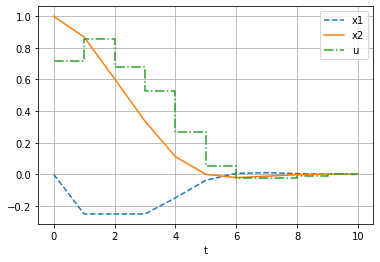

In [40]:
x_opt = sol['x'].full().flatten()

# Plot the solution
x1_opt = x_opt[0::3]
x2_opt = x_opt[1::3]
u_opt = x_opt[2::3]

tgrid = [T/N*k for k in range(N+1)]
import matplotlib.pyplot as plt
plt.figure(1)
plt.clf()
plt.plot(tgrid, x1_opt, '--')
plt.plot(tgrid, x2_opt, '-')
plt.step(tgrid, ca.vertcat(ca.DM.nan(1), u_opt), '-.')
plt.xlabel('t')
plt.legend(['x1','x2','u'])
plt.grid()
plt.show()

Double integrator test: evaluate the approximated integration of stage cost with *Sympy*

In [41]:
# x0,x1 = sy.symbols('x0:2')
x_init0,x_init1 = sy.symbols('x_init0:2')
u = sy.symbols('u')
t = sy.symbols('t')

x0 = x_init0 + x_init1 * t + 1/2 * u * t**2
x1 = u*t + x_init1

integral = x0**2 + x1**2 + u**2
integral_num = integral.subs({x_init0:1,x_init1:2,u:1})
integral_num

(t + 2)**2 + 4*(0.25*t**2 + t + 1/2)**2 + 1

In [26]:
sy.integrate(integral_num, (t,0,1))

12.5500000000000